In [54]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as py
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras import backend as K

# Training a Lightweight Model to create super resolution satellite Images

1. Because of computational limits, a relatively lightweight solution is implemented
2. The Model uses 1 km MODIS Images, and creates a 250 meter visual product. 
3. The model is an autoencoder, which first encodes /upscales the 1 km images to a 4 km product, it then learns spatial features from the 4 km resolution image and tries to return it to the original 1km resolution
4. Further updates of this document will include implementation of custom loss functions to get sharper images.

## Loading the Satellite Imagery from the Repository
1. Unzip the files to load them into memory (too large for a github repository).

In [2]:
f = Dataset(r"C:\Users\rampaln\Downloads\Training_Dataset_Final.nc")
training_data = f['Reflectance'][:].data
X_train = training_data[0:1000]
X_test = training_data[1000:]

# Dataset
1. Consists of Cellular Clouds with Open-celled domains, closed-celled domains, disorganised cellular domains, and "stratus like clouds"
2. These are labelled in the Dataset (see dataset attributes).

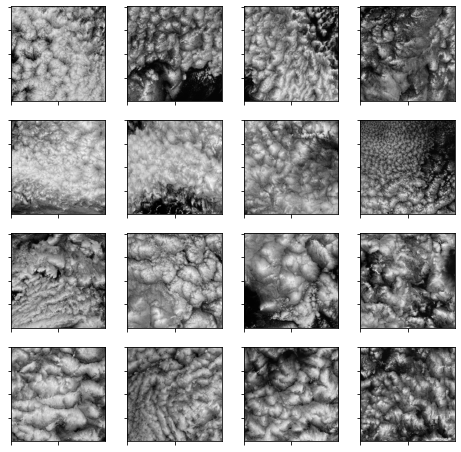

In [3]:
fig, ax = py.subplots(4,4, figsize = (8,8))
ax = ax.ravel()
for i, axes in enumerate(ax):
    axes.imshow(X_train[i], cmap ='gray')
    axes.set_yticklabels([])
    axes.set_xticklabels([])

## Creating a Model
1. Input shape is one-eighth of the original data

In [152]:
input_img = Input(shape=(100, 100, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (9, 9), activation='relu', padding='same')(input_img)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
encoded = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
#x = Conv2D(512, (7, 7), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [153]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 100, 16)      1312      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 64)        51264     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 50, 50, 64)        102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0  

## Training the model (only training it on half the image domain)

In [154]:
#superresolution = Model(encoded, decoded)
sub_sample_train = X_train[:,:100,:100,np.newaxis]
sub_sample_test = X_test[:,:100,:100,np.newaxis]
autoencoder.fit(sub_sample_train,sub_sample_train,
                epochs=30,
                batch_size=40,
                shuffle=True,
                validation_data=(sub_sample_test,sub_sample_test))#,

Train on 1000 samples, validate on 421 samples
Epoch 1/30
1000/1000 [==============================] - 134s 134ms/step - loss: 0.0967 - val_loss: 0.0425
Epoch 2/30
1000/1000 [==============================] - 144s 144ms/step - loss: 0.0231 - val_loss: 0.0080
Epoch 3/30
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 4/30
1000/1000 [==============================] - 148s 148ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/30
1000/1000 [==============================] - 140s 140ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 6/30
1000/1000 [==============================] - 148s 148ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 7/30
1000/1000 [==============================] - 150s 150ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 8/30
1000/1000 [==============================] - 150s 150ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/30
1000/1000 [==============================] - 153s 153ms/step - loss: 0.0023 - val_loss: 0.0020

In [155]:
autoencoder.save('model_higher_res.h5')


In [158]:
encoding_dim = (200,200,1)
encoded_input = Input(shape=encoding_dim)
x = encoded_input
for layer in autoencoder.layers[-7:]:
    x = layer(x)
Models = Model(encoded_input, x)

In [159]:
Models.save('superresolution_model_further.h5')

In [160]:
data = Models.predict(X_test[:50,:,:,np.newaxis])

## Full Size Comparison of Super resolution vs Original Images
1. Full size examples are hard to compare, but images are slightly sharper
2. Sharpness of images will be improved in further updates
3. Original 1 km Image is on the left

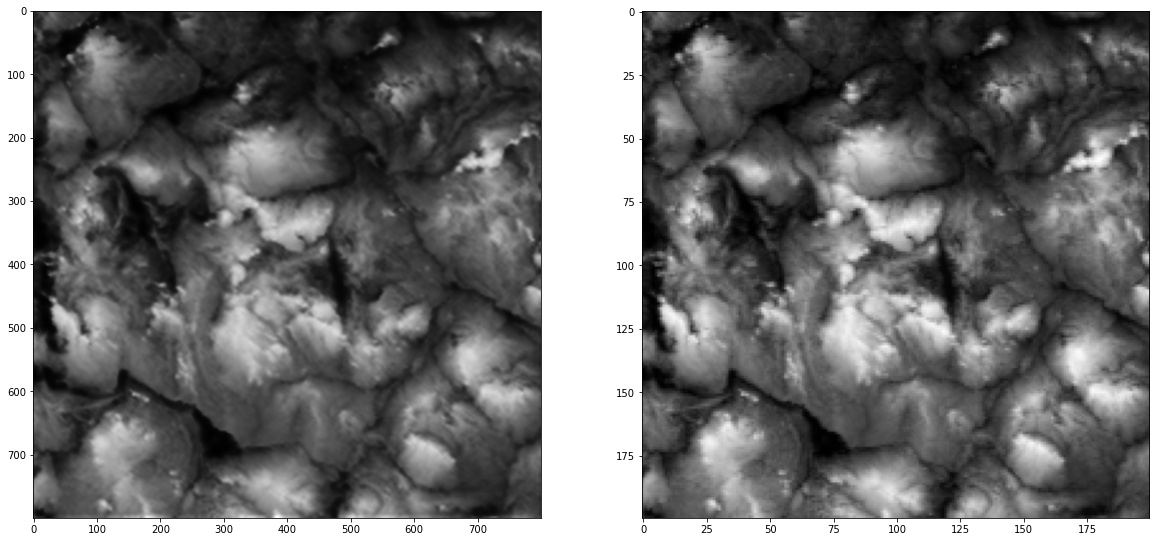

In [161]:
idx_of_interest = 10
fig, ax = py.subplots(1,2, figsize = (20,20))
ax[0].imshow(data[idx_of_interest,:,:,0], cmap ='gray')
ax[1].imshow(X_test[idx_of_interest,:,:], cmap='gray')

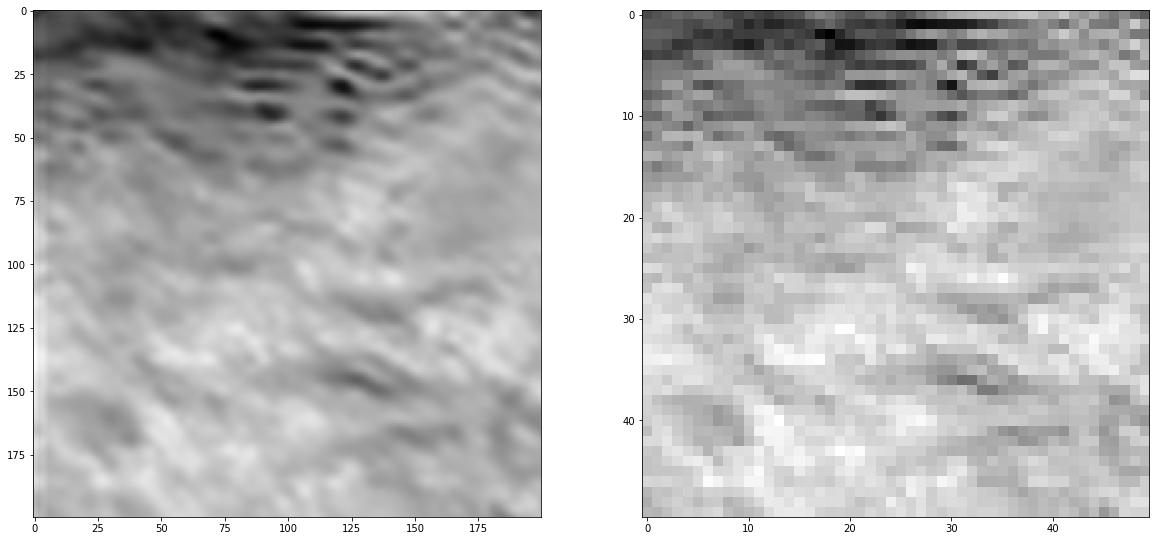

In [162]:
idx_of_interest = 46
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])

# Examples of Images

1. Note the Images below are small segmentations of the original domains

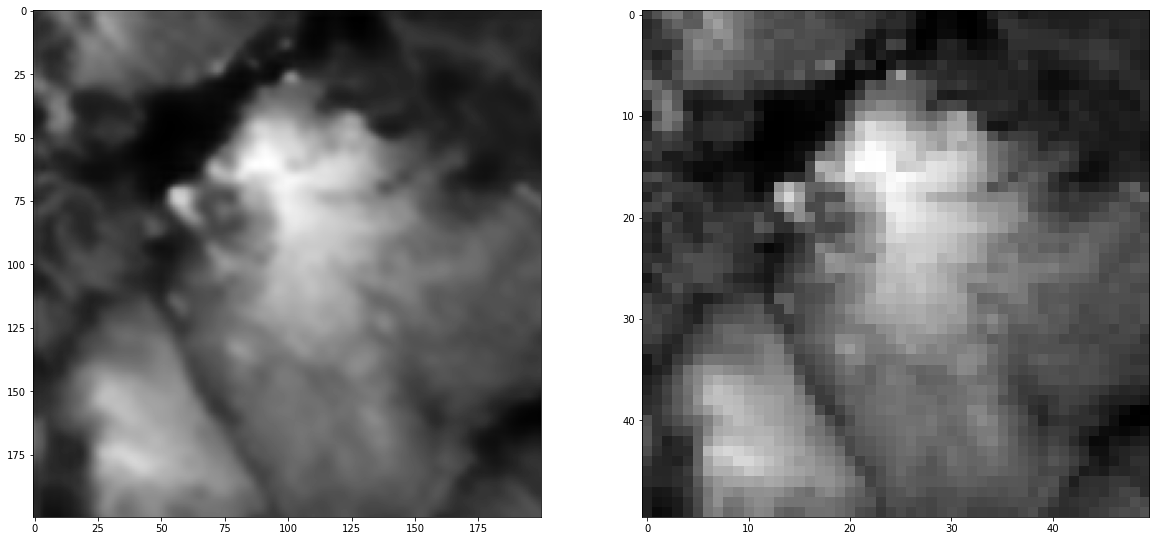

In [172]:
idx_of_interest = 10
fig, ax = py.subplots(1,2, figsize = (20,20))
ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')
ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')
#ax[2].imshow(X_test[:,:100,:100,np.newaxis][idx_of_interest,::4,::4,0],cmap='gray')
#ax[2].imshow(X_test[idx_of_interest],cmap='gray')

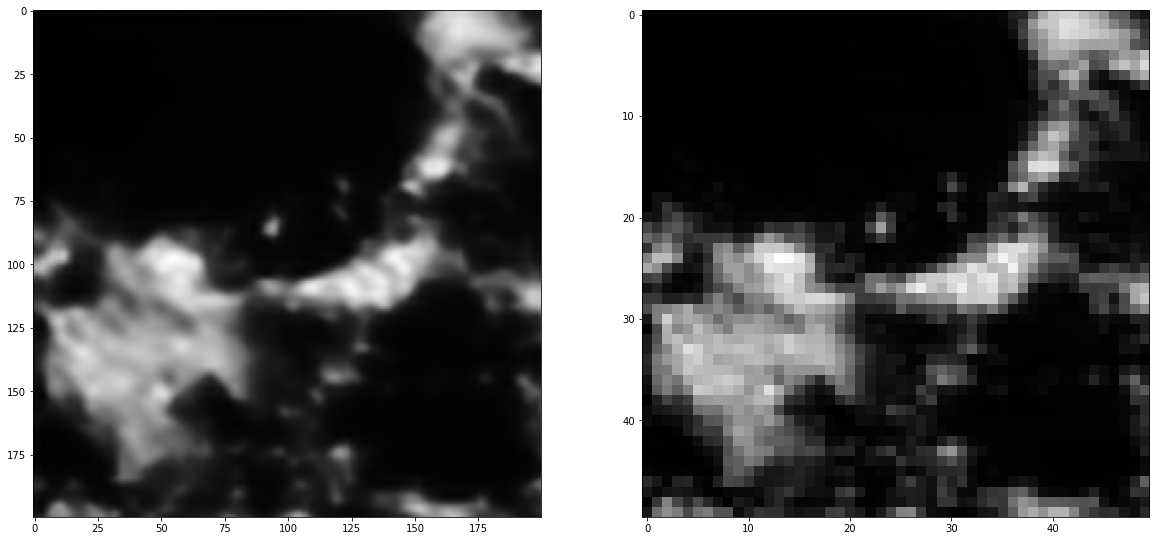

In [165]:
idx_of_interest = 19
fig, ax = py.subplots(1,2, figsize = (20,20))
ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')
ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')

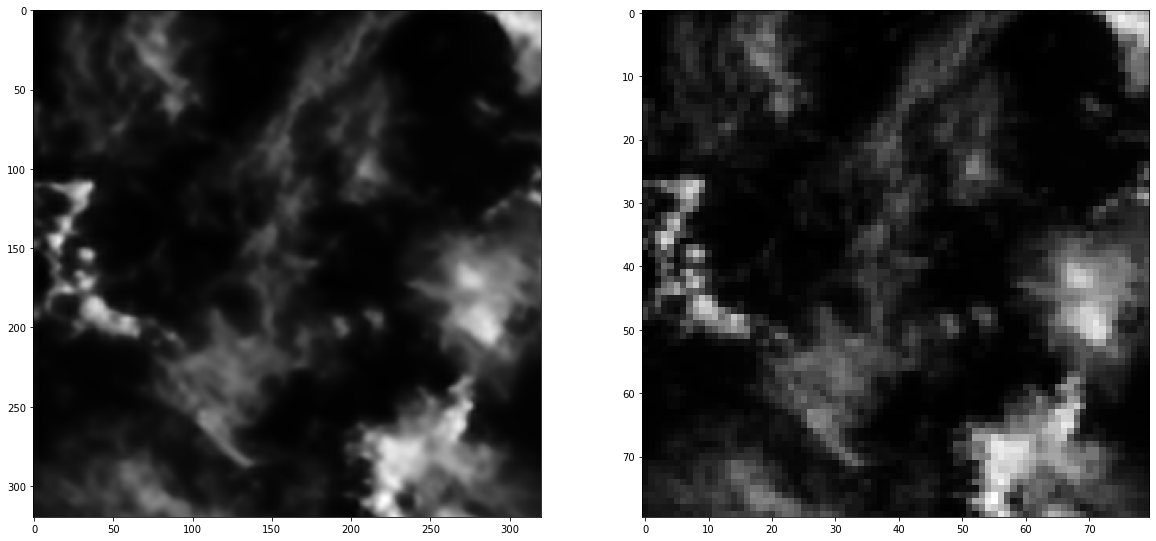

In [169]:
idx_of_interest = 25
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:80*4,:80*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:80,:80], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])
#fig.colorbar(cs, cax = ax4)


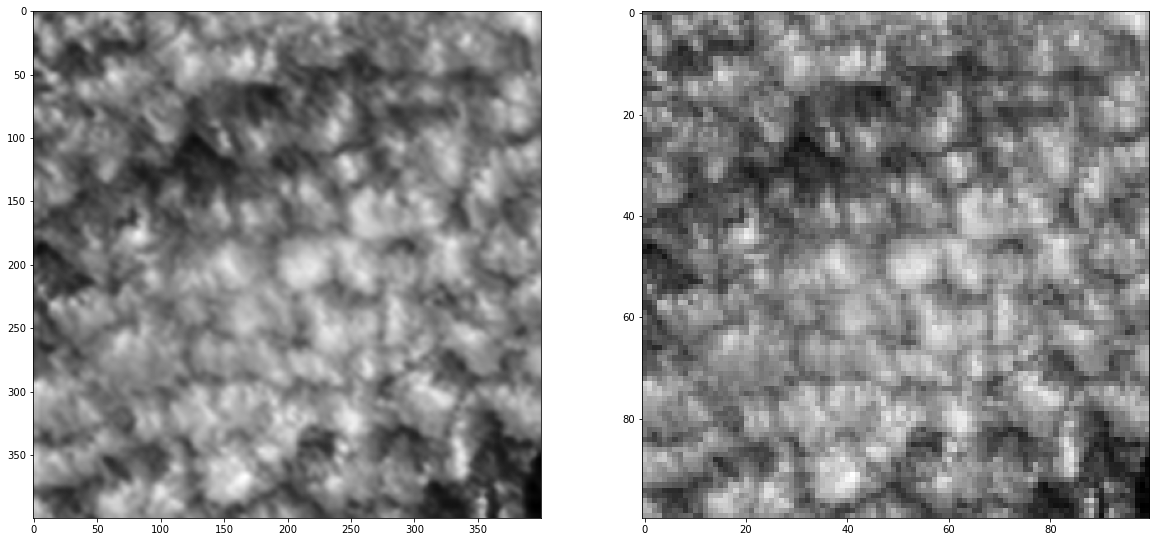

In [168]:
idx_of_interest = 28
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:100*4,:100*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:100,:100], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])
#fig.colorbar(cs, cax = ax4)

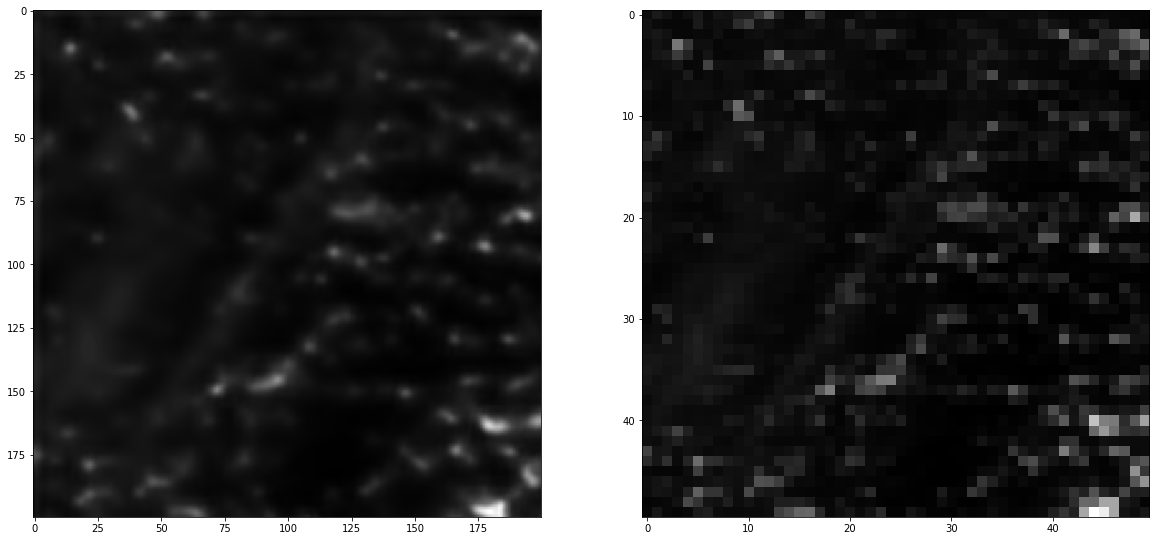

In [170]:
idx_of_interest = 33
fig, ax = py.subplots(1,2, figsize = (20,20))
cs = ax[0].imshow(data[idx_of_interest,:,:,0][:50*4,:50*4], cmap ='gray')#,vmin =0, vmax =0.8)
cs2 = ax[1].imshow(X_test[idx_of_interest,:,:][:50,:50], cmap='gray')#,vmin =0, vmax =0.8)
#ax4 = fig.add_axes([0.95,0.25,0.01,0.5])
#fig.colorbar(cs, cax = ax4)idx_of_interest],cmap='gray')
